In [2]:
include("gravity-tools.jl")
include("trade-environment.jl")
include("simmulate-trade-models.jl")
include("estimate-trade-models.jl")
using CSV
using DataFrames
using Plots
using MINPACK
using Optimization
using OptimizationOptimJL
using OptimizationPRIMA
using LinearAlgebra


In [3]:
directory = "./data/"
yyy = "2017"

df, dftrade, dfcountryfix = make_trade_data(directory, yyy)
# this is a function to construct the trade data


θ = 5.0 # initial value for the trade elasticity
σ = 2.0 # the CES parameter which may or may not matter
Ncntry = 30 # number of countries, for these datasets this is always 30.

grv_params = gravity_params(Ncntry = Ncntry, θ = θ, L = ones(Ncntry), dfcntryfix = dfcountryfix )

gravity_params
  Ncntry: Int64 30
  θ: Float64 5.0
  L: Array{Float64}((30,)) [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
  dfcntryfix: DataFrame


In [4]:
grvdata = gravity(dftrade, display = false);
# this function runs the gravity regression and returns the 
# coefficients and the fixed effects. The fixed effects are used to construct the trade costs and the technology parameters.

d = zeros(Ncntry,Ncntry)
T = zeros(Ncntry)
W = ones(Ncntry)

make_trade_costs!(grvdata, d, grv_params)

make_technology!(grvdata, T, W, grv_params)


trd_prm = trade_params(θ = grv_params.θ, σ = σ, d = d, S = exp.(grvdata.S), Ncntry = grv_params.Ncntry, N = grv_params.L)
# this is a structure that has everything we neeed to simulate a trade model.


trade_params
  θ: Float64 5.0
  σ: Float64 2.0
  d: Array{Float64}((30, 30)) [1.0 3.0949251208186275 … 3.0949251208186275 3.0949251208186275; 3.652970409828579 1.0 … 2.5207451062604918 3.3900234976551302; … ; 2.634931840787981 1.8182440035992344 … 1.0 2.445265045388121; 1.9599262781902596 1.8188475107436017 … 1.8188475107436017 1.0]
  N: Array{Float64}((30,)) [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
  S: Array{Float64}((30,)) [0.5149706138452046, 0.537630876504359, 0.9805668300763852, 1.1289062390565394, 1.0882101519222518, 20.146691011935648, 0.0931305651101304, 0.35992382790410643, 0.3714598343463075, 2.0767098972246703  …  0.6533944932460338, 0.21920664475361276, 0.502923302286091, 1.3531279507273013, 0.7599392942958461, 1.0537492856737725, 1.4356246138310333, 0.5172298984987407, 1.8244286235731, 11.762967657899992]
  T: Array{Float64}((30,)) [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 

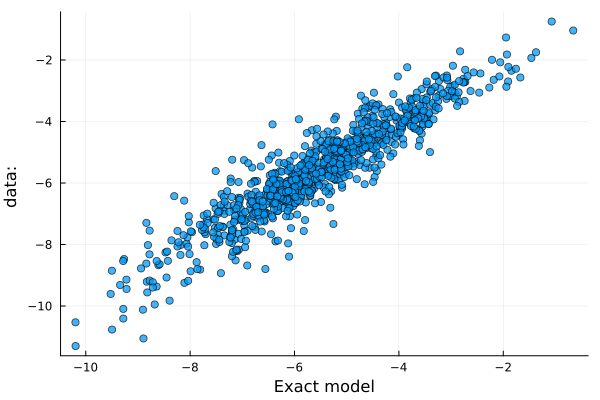

In [6]:
πshares_exact, Φ =eaton_kortum(trd_prm)

dfmodel_exact = make_trademodel_dataframe(πshares_exact, dfcountryfix)
# merge this up with the real data so we can plot


plot(log.(dfmodel_exact.tradeshare), log.(dfmodel_exact.tradedata), seriestype = :scatter, alpha = 0.75,
    xlabel = "Exact model",
    ylabel = "data: ",
    legend = false)

    # savefig("C:\\github\\minnesota-phd-trade-2026\\notes\\figures\\data_model_exact_fit.png")

  1.472282 seconds (6.07 k allocations: 343.444 MiB, 0.93% gc time)


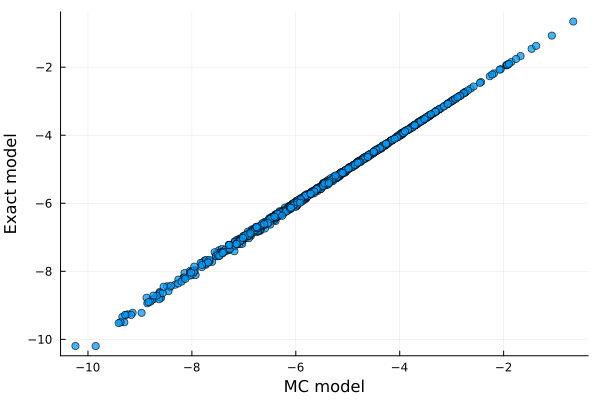

In [9]:
Ngoods = 500000
code = 300

@time πshares, prices = sim_trade_pattern_ek(trd_prm; Ngoods = Ngoods, code = code);
# this is the code that simmulates and constructs the trade using 
# Monte Carlo integration. 


dfmodel = make_trademodel_dataframe(πshares, dfcountryfix)
# merge this up with the real data so we can plot



plot(log.(dfmodel.tradeshare), log.(dfmodel_exact.tradeshare), seriestype = :scatter, alpha = 0.75,
    xlabel = "MC model",
    ylabel = "Exact model",
    legend = false)

# savefig("C:\\github\\minnesota-phd-trade-2026\\notes\\figures\\mc_vs_exact_model_fit.png")

In [10]:
Ngoods = 100000
code = 300

@time bejkπshares, prices, markups = sim_trade_pattern_bejk(trd_prm; Ngoods = Ngoods, code = code);
# this is the code that simmulates and constructs the trade using 
# Monte Carlo integration. 

  1.349981 seconds (438.16 k allocations: 136.539 MiB, 15.82% gc time, 53.83% compilation time)


([0.6369673439772776 0.0024679672083174732 … 0.00759852720546794 0.05039571865942503; 0.0007686356557926436 0.5448362036637892 … 0.01780191876590569 0.025777833684523715; … ; 0.0009230092100952098 0.006983763617634274 … 0.4582891050521357 0.03252568613281111; 0.0011088754575551908 0.0017587603535290887 … 0.005940131891580536 0.7776290818509848], [1.2644127698954375 1.195960435560722 … 1.1531369338316342 1.381078543587125; 1.0751651100114559 1.309994206820847 … 1.1190343764059758 1.3546132473138277; … ; 0.7755296278478313 0.8531475302974264 … 0.829812156721025 0.9433507190725748; 0.8367138642816716 0.5164879508790374 … 0.7313975994084222 0.7397228561635611], [1.0455416432226154 1.1242733822895712 … 1.1835446704051982 1.569352894505099; 1.2360845190274439 1.017482039434151 … 1.003807895852299 1.2398130148695425; … ; 1.223045721363847 1.220265677854157 … 1.1244605892739643 1.6445436142982843; 1.1260092235245678 1.2709030520805829 … 1.239298325720197 1.2161203377800345])

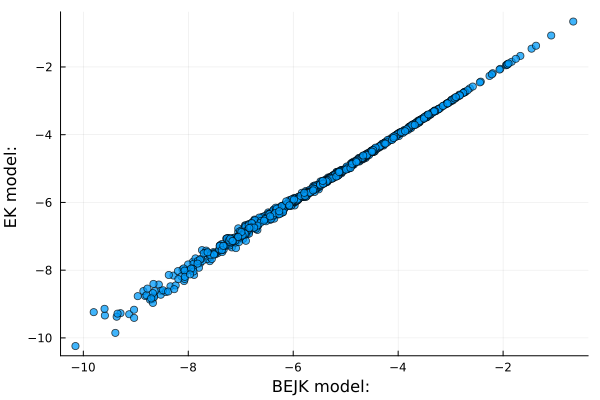

In [11]:
dfmodelbejk = make_trademodel_dataframe(bejkπshares, dfcountryfix)
# merge this up with the real data so we can plot


plot(log.(dfmodelbejk.tradeshare), log.(dfmodel.tradeshare), seriestype = :scatter, alpha = 0.75,
    xlabel = "BEJK model: ",
    ylabel = "EK model: ",
    legend = false)

# savefig("C:\\github\\minnesota-phd-trade-2026\\notes\\figures\\bejk_trade_model_fit.png")


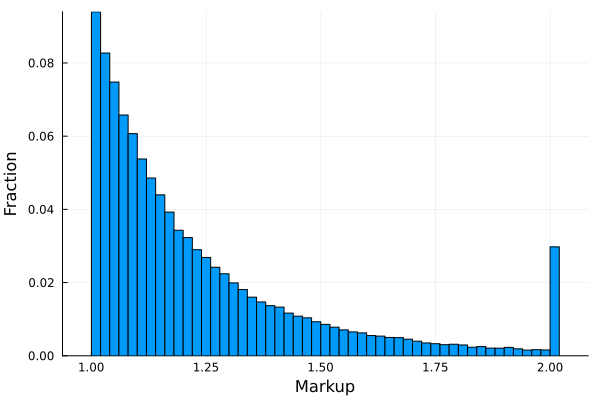

In [13]:
cntry = 30  # or whichever country index you want

histogram(markups[cntry, :], 
    bins = 50,                    # number of bins
    normalize = :probability,     # values as fractions
    xlabel = "Markup", 
    ylabel = "Fraction",
    legend = false)